# Diferencias entre Lasso, Ridge y Elastic Net

a) Por un lado, Ridge Regression no discrimina variables, por lo que no podemos obtener un modelo parsimonioso a partir de este método; sin embargo, posee un efecto de agrupación de variables.

b) Por otro lado, Lasso discrimina variables por completo y puede arrojar un modelo parsimonioso. El problema es que Lasso llevará a cero parámetros de variables con el mismo poder predictivo. 

Elastic Net es una combinación lineal entre ambos mediante la norma $\alpha$ y, por tanto, discrimina por grupos. 


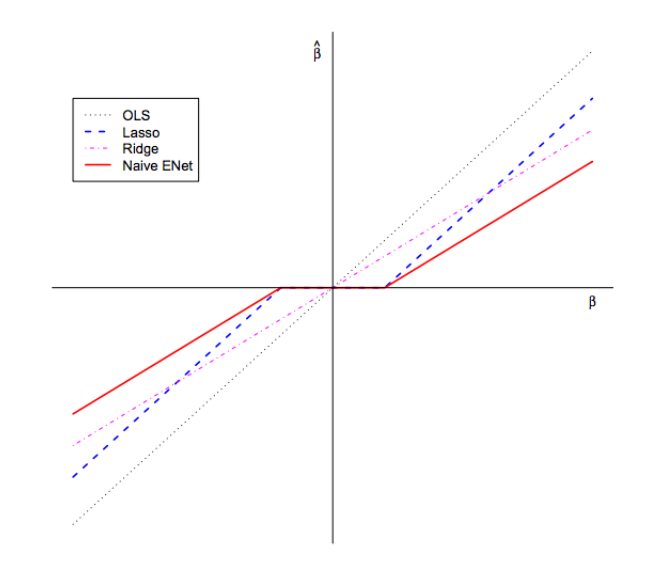

In [119]:
from IPython.display import Image
Image(filename='picexactsolutions.png')

# Veamos cómo se hace en Python

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

data_cr = pd.read_excel('Credit (1).xlsx')

nobs    = data_cr.shape[0]
saldo    = np.asarray(data_cr.Balance).reshape((nobs,1))
male     = np.asarray(data_cr.Gender==' Male').reshape((nobs,1))
student  = np.asarray(data_cr.Student=='Yes').reshape((nobs,1))
married  = np.asarray(data_cr.Married=='Yes').reshape((nobs,1))
eth_dum  = np.asarray(pd.get_dummies(data_cr.Ethnicity))[:,:-1]
oth_xmat = data_cr[[u'Income', u'Limit', u'Rating', u'Cards', u'Age', u'Education']]

labs_x = np.array([u'Income', u'Limit', u'Rating', u'Cards', u'Age', u'Education',
              'Hombre','Estudiante','Casado','Caucasian','Asian'])

prexmat  = np.concatenate((oth_xmat, male, student, married, eth_dum),axis=1)
#print prexmat.shape
nvar = prexmat.shape[1]
# I will start by standardizing/normalizing the matrix
prexmat_std = prexmat.copy()
ind_dum = np.array([pd.Series(prexmat[:,k]).unique().shape[0] for k in range(nvar)])
prexmat_std[:,ind_dum>2] -= prexmat_std[:,ind_dum>2].mean(axis=0).reshape((1,6))
# get the norms
norm_pxmat = np.array([np.linalg.norm(prexmat_std[:,ind_dum>2][:,k]) for k in range(np.sum(ind_dum>2))])
# ready to normalize
prexmat_std[:,ind_dum>2] /= prexmat_std[:,ind_dum>2].std(axis=0).reshape((1,6))


# also standardize y
#yy_std = saldo.copy()
#yy_std -= yy_std.mean()
#yy_std /= yy_std.std()

# Diferencias entre Ridge, Lasso y Elastic Net  en Scikit-learn

In [115]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=1.0, copy_X = True,fit_intercept=True, max_iter=1000000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='random', tol=0.0001, warm_start=False)
clf.fit(prexmat_std,yy_std)
pd.DataFrame(clf.coef_, index = labs_x, columns=['Lasso'])

,Lasso
Income,-181.864774
Limit,225.993209
Rating,295.353076
Cards,1.073672
Age,-0.000000
Education,-0.000000
Hombre,0.000000
Estudiante,348.311853
Casado,-0.000000
Caucasian,-0.000000


In [109]:
# importemos el método
from sklearn.linear_model import Ridge
# llamemos el método, con alpha = 1.0
clf = Ridge(alpha=.5, fit_intercept=True, normalize=True, copy_X=True, max_iter=None, tol=0.001, solver='auto')
# Ajustemos el modelo
clf.fit(prexmat, yy_std)
# imprimamos los coeficientes estimados
coef_scikit = pd.DataFrame(clf.coef_.T, index= labs_x, columns=['Ridge'])
print coef_scikit

                 Ridge
Income       -1.059305
Limit         0.074367
Rating        1.105899
Cards        15.093542
Age          -1.015346
Education     0.017617
Hombre       -3.286943
Estudiante  267.862696
Casado      -11.147953
Caucasian    -6.746213
Asian         0.867821


In [116]:
from sklearn import linear_model
clf = linear_model.ElasticNet(alpha=1.0, l1_ratio=0.5 , copy_X = True,fit_intercept=True, max_iter=1000000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
clf.fit(prexmat_std,yy_std)
pd.DataFrame(clf.coef_, index = labs_x, columns=['Elastic Net'])


,Elastic Net
Income,0.994403
Limit,1.905411
Rating,1.909799
Cards,0.147316
Age,0.000000
Education,-0.000000
Hombre,-0.000000
Estudiante,1.806573
Casado,-0.000000
Caucasian,0.000000


Tenemos muy pocas variables como para apreciar el efecto de Elastic Net al incluir grupos. 

# Paths de Lasso y Elastic Net 

Trayectoria de regularización mediante Lasso
Trayectoria de regularización mediante Elastic Net


(-1.7516642349615168,
 0.64627577371052081,
 -12.912227565586411,
 26.548247699229638)

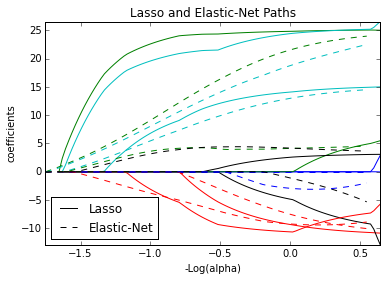

In [118]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import lasso_path, enet_path
from sklearn import datasets

diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

X /= X.std(axis=0)  # Estandaricemos los datos

#Listos para hallar las trayectorias

eps = 5e-3  # mientras más chico, más grande es el path

print("Trayectoria de regularización mediante Lasso")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps, fit_intercept=False)

print("Trayectoria de regularización mediante Elastic Net")
alphas_enet, coefs_enet, _ = enet_path(
    X, y, eps=eps, l1_ratio=0.8, fit_intercept=False)

# Resultados

plt.figure(1)
ax = plt.gca()
ax.set_color_cycle(2 * ['b', 'r', 'g', 'c', 'k'])
l1 = plt.plot(-np.log10(alphas_lasso), coefs_lasso.T)
l2 = plt.plot(-np.log10(alphas_enet), coefs_enet.T, linestyle='--')

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and Elastic-Net Paths')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='lower left')
plt.axis('tight')


# Fuente: Alexandre Gramfort <alexandre.gramfort@inria.fr>

## Pseudocódigo de Elastic Net mediante Univariate Soft Thresholding 
**1.** Fijamos lambdas

**2.** Inicializamos betas

**3.** while dist > $threshold$

**4.**  $\forall k \in \{x_1, …, x_P\}$ (for k in range($P$))

**5.** Calculamos residuos excluyendo el regresor k
$$    
    r_{-k} = y - x_{-k}\beta_{-k}
$$ 


**6.** OLS simple de k
$$    
    \beta^*_{k} = \frac{1}{N} r_{-k}'x_k = \frac{1}{N} \sum_j r_{-k,j}x_{jk}
$$

**7.** Actualizamos beta mediante la regla de actualización de naive elastic net (única diferencia entre Lasso y Elastic Net)

$$\hat{\beta_k} = \Big( \frac{\beta_{k-1}-\frac{\lambda_1}{2}}{1+\lambda_2}\Big)_{+}sgn(\beta_{k-1})$$

**7'.** Reescalamos para quitar el sesgo:
$$\hat{\beta_{EN}} = (1+\lambda_2)\beta_k$$
**8.** $d = \beta_{k} - \beta_{k-1}$ (actualizamos distancia)

Es importante resaltar que UST ignora la dependencia que hay entre predictores. Es decir, los trata como coeficientes de una regresión univariada (Frisch-Waugh).